## ASHRAE Great Energy Predictor III
Matt and Will pair programming exercise for MadPy Meetup Hackathon on Nov 14, 2019

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

% matplotlib inline
sns.set_context('poster')
sns.set_style('dark')
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['lines.markeredgewidth'] = 2

# Exploratory analysis
Let's load the data and do some exploratory analysis and visualization. This notebook assumes that all of kaggle files are in the current directory.

In [2]:
# Load the training data
df_building = pd.read_csv('building_metadata.csv')
df_train = pd.read_csv('train.csv')
df_weather_train = pd.read_csv('weather_train.csv')

Let's look at the structure of the data

In [3]:
df_train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [4]:
df_building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [5]:
df_weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


We can join df_train and df_building on building_id. We'll look into the weather data later on.

In [6]:
df_train = df_train.merge(df_building, how='left', on='building_id')
#df_train = df_train.merge(df_weather_train, how='left', on=['site_id', 'timestamp'])

In [7]:
# Convert timestamp to datatime and plot the meter reading over time for a few buildings and meters
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_train['day'] = df_train['timestamp'].dt.floor('d')
df_train['month'] = df_train['timestamp'].dt.month
df_train['hour'] = df_train['timestamp'].dt.hour

### Plot the meter reading vs. hour for each site averaged over the year
We'll group by site_id and hour and calculate the mean. This should give us a general idea of how the meter reading varies with time. I'd expect to max out around the early afternoon when the temperature is high and buildings are in use.

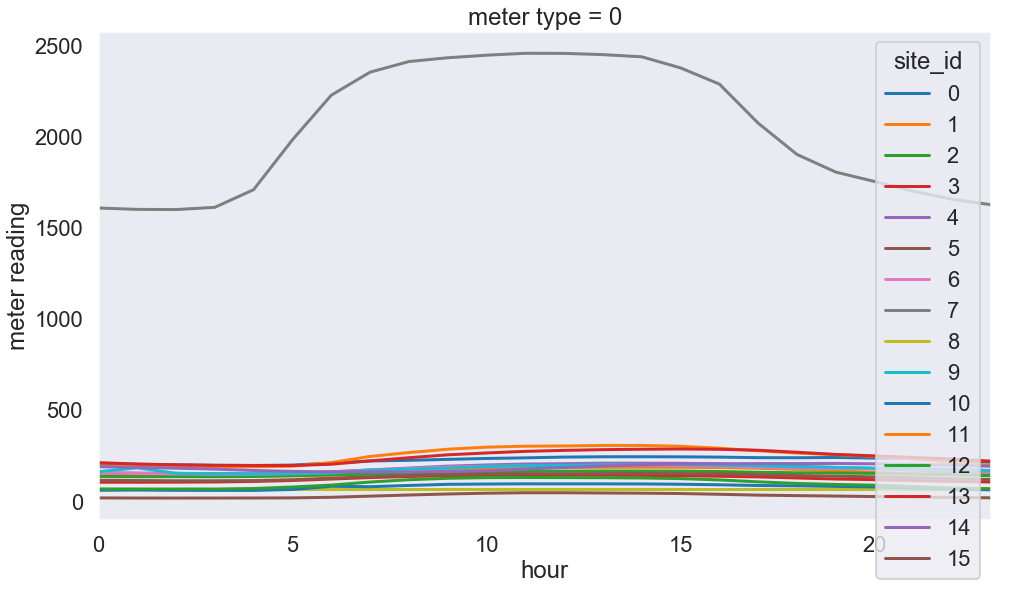

In [8]:
# Make the plot for each meter type independently
meter_types = df_train['meter'].unique()
site_ids = df_train['site_id'].unique()

for meter_type in [0]:
    fig, ax = plt.subplots()
    ax.set_ylabel('meter reading')
    ax.set_title('meter type = {}'.format(meter_type))
    df = df_train[df_train['meter']==meter_type].groupby(['site_id', 'hour']).mean()
    for site_id in site_ids:
        try:
            df.loc[site_id,:]['meter_reading'].plot(ax=ax, label=site_id)
        except:
            pass
    ax.legend(title='site_id')

Site 7 is clearly an outlier, so let's ignroe that for now and look at the other sites

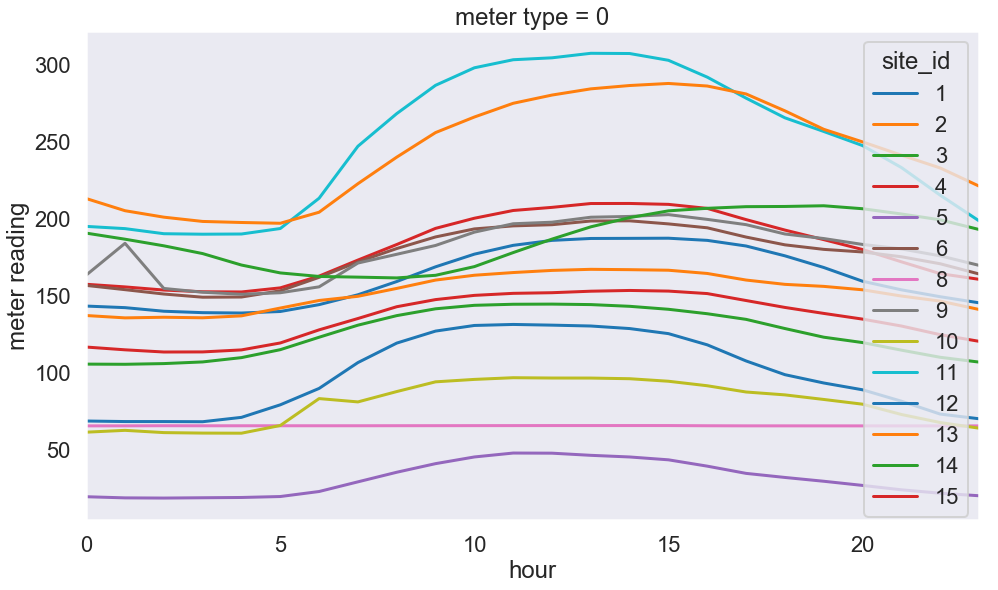

In [9]:
# Ignore site 7
site_ids = [x for x in range(1,16) if x!=7]
meter_type = 0

fig, ax = plt.subplots()
ax.set_ylabel('meter reading')
ax.set_title('meter type = {}'.format(meter_type))
df = df_train[df_train['meter']==meter_type].groupby(['site_id', 'hour']).mean()

for site_id in site_ids:
    df.loc[site_id,:]['meter_reading'].plot(ax=ax, label=site_id)
ax.legend(title='site_id')

This generally agrees with the intuition that the meter reading should peak in the early afternoon when the temperature peaks, on average. We should take a deeper look at the site 7 data to see what's going on. Ideally, we should also look at the time series for each building at each site to look for outliers...

## Weather data exploration

In [10]:
df_weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [11]:
# Convert the timestamp to datatime and get the hour
df_weather_train['timestamp'] = pd.to_datetime(df_weather_train['timestamp'])
df_weather_train['hour'] = df_weather_train['timestamp'].apply(lambda x: x.hour)

We're not sure if the timestamps are the local time at each site, so we want to plot mean temperature per hour over the whole data set for each site. The peak of the air temperature should be at roughly the same local time each day.

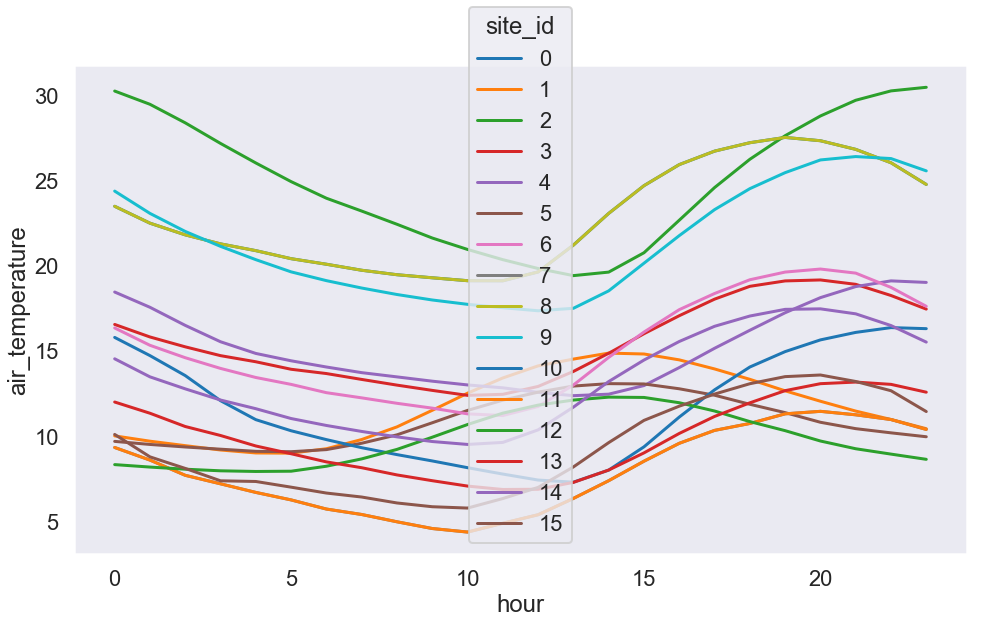

In [12]:
gb = df_weather_train.groupby(['site_id', 'hour'], as_index=False).mean()
fig, ax = plt.subplots()
for site_id in np.unique(gb['site_id']):
    site_mask = gb['site_id'] == site_id
    ax.plot(gb['hour'][site_mask], gb['air_temperature'][site_mask], label=site_id)
    ax.set_xlabel('hour')
    ax.set_ylabel('air_temperature')
    ax.legend(title='site_id')

The peaks are not aligned, which indicates that the timestamps are probably not local. We can find the hour of the maximum temperature at each site, then shift the hour by the maximum in order to normalize the hours. This way they are all standardized and meaningful. 

In [13]:
# Find index of the hour of the maximum air temperature for each site 
max_idx = df_weather_train.groupby(['site_id', 'hour']).mean().groupby(['site_id'])['air_temperature'].idxmax()

In [14]:
# Shift the hours at each site by its the hour of the maximum air temperature
df_weather_train['hour_shifted'] = np.nan
gb = df_weather_train.groupby(['site_id', 'hour'])
max_hours = max_idx.apply(lambda x: x[1])
for s, max_hr in enumerate(max_hours):
    df_weather_train.loc[df_weather_train['site_id'] == s, 'hour_shifted'] = df_weather_train[df_weather_train['site_id'] == s]['hour'] - max_hr

In [15]:
# Find shifted hour modulus 24 to fix wrap around so that the maximum shifted hour is now at 0
df_weather_train['hour_shifted'] = df_weather_train['hour_shifted'] % 24

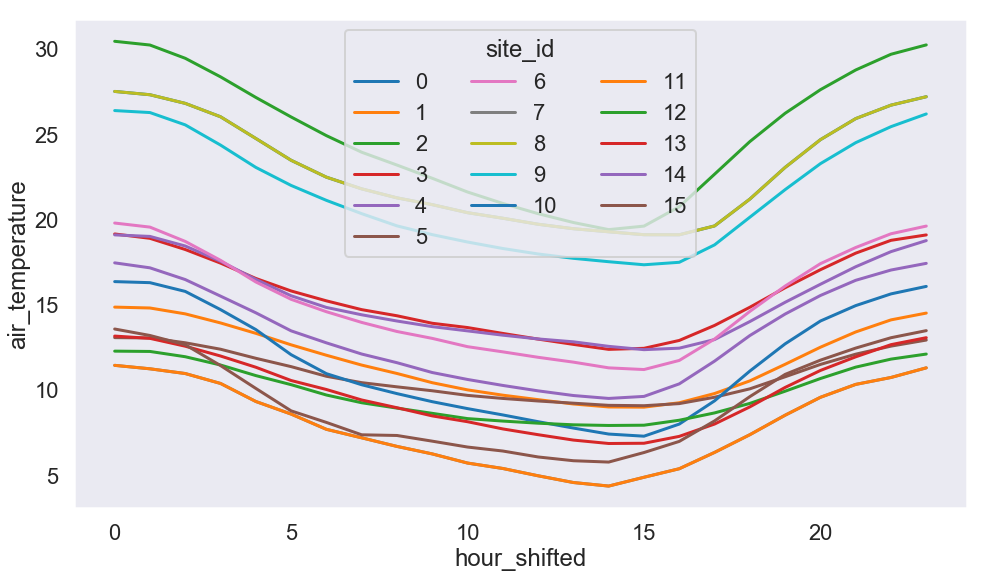

In [16]:
# Plot shifted hour vs air temperature at each site to see if it worked
gb = df_weather_train.groupby(['site_id', 'hour_shifted'], as_index=False).mean()
fig, ax = plt.subplots()
for site_id in np.unique(gb['site_id']):
    site_mask = gb['site_id'] == site_id
    ax.plot(gb['hour_shifted'][site_mask], gb['air_temperature'][site_mask], label=site_id)
    ax.set_xlabel('hour_shifted')
    ax.set_ylabel('air_temperature')
    ax.legend(title='site_id', ncol=3)

## Using the normalized weather data 
We've now shifted the weather time series so that the average maximum temperatures are lined up at hour 0 for each site. A big question now is how to make use of this data since the times are not in sync with the locals times at each site. We _could_ feed the weather data into a model as is and the model may be able to learn the translation between the weather time series and the meter reading time series at each site. Another option would be to align the temperature maximum at each site with the meter reading maximum. Naively I would expect this to translate the weather timestamps to local time, since the maximum meter reading (for electricity!) should occur around the same time as the maximum temperature. Of course we can (and should, given enough time/resources) try both and see which performed better.